In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [49]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [50]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [51]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [52]:
X_train = X_train.float()
X_test = X_test.float()

In [53]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [54]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

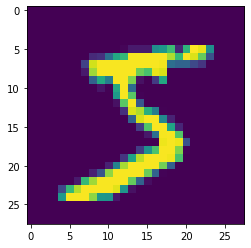

tensor(5)


In [55]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [56]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [57]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [58]:
torch.cuda.is_available()

True

In [59]:
!nvidia-smi

Wed Jun 22 03:39:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   1366MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0254,  0.0228,  0.0056,  ..., -0.0114, -0.0035,  0.0225],
         [ 0.0172, -0.0139,  0.0192,  ..., -0.0083,  0.0045, -0.0206],
         [-0.0070, -0.0057, -0.0128,  ...,  0.0213, -0.0036, -0.0149],
         ...,
         [-0.0313, -0.0216, -0.0193,  ...,  0.0117, -0.0023,  0.0258],
         [-0.0287,  0.0331,  0.0078,  ..., -0.0292,  0.0341,  0.0044],
         [-0.0283,  0.0104, -0.0145,  ..., -0.0129,  0.0160, -0.0128]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 1.7559e-02, -4.3088e-03,  5.8947e-04, -1.5237e-02, -5.7202e-03,
          2.0320e-02, -2.6771e-02,  1.5046e-03, -3.6740e-03,  2.7314e-02,
         -3.5267e-02,  1.6202e-03,  2.5047e-03,  2.3932e-02,  1.5547e-02,
          2.2168e-03,  1.7947e-02, -8.8012e-03,  9.5497e-03, -2.1096e-02,
          3.3168e-02, -3.3898e-02, -6.6754e-03,  1.5277e-02, -1.8927e-03,
         -1.6423e-02,  1.8165e-02, -8.7630e-04,  3.4078e-02, -7.3070e-03,
          1.0132e-02,  1

In [61]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [69]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
#     test_loss_history.append(loss(test_preds, y_test))
    test_loss_history.append(loss(test_preds, y_test).cpu().detach().numpy())
    
#    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu().detach().numpy()
    test_accuracy_history.append(accuracy)
    print(accuracy)

0.95489997
0.95589995
0.9561
0.9578
0.959
0.95949996
0.95989996
0.9596
0.9562
0.95409995
0.9597
0.95629996
0.96209997
0.9579
0.95879996
0.959
0.95699996
0.9593
0.9604
0.9571
0.95409995
0.9586
0.9582
0.958
0.959
0.95739996
0.9594
0.95809996
0.9589
0.9583
0.9586
0.95919997
0.96239996
0.96099997
0.96019995
0.9618
0.96239996
0.96029997
0.9608
0.95629996
0.959
0.9622
0.9607
0.9614
0.9583
0.959
0.9589
0.96019995
0.96029997
0.95769995
0.9614
0.9596
0.9576
0.9578
0.95989996
0.9594
0.9619
0.96
0.9632
0.9612
0.9575
0.9598
0.96089995
0.9612
0.96349996
0.96239996
0.9625
0.96269995
0.9593
0.95949996
0.9608
0.9601
0.9614
0.9605
0.95879996
0.9604
0.9607
0.9626
0.96159995
0.9622
0.9605
0.9589
0.96099997


KeyboardInterrupt: ignored

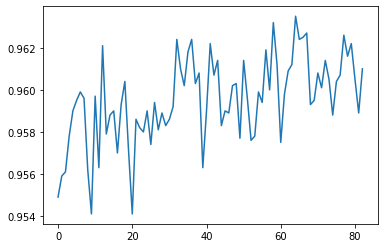

In [73]:
plt.plot(test_accuracy_history)

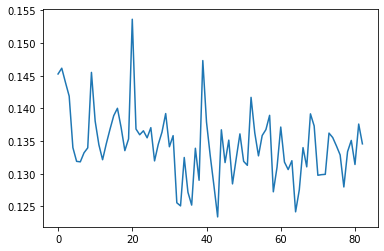

In [72]:
plt.plot(test_loss_history);

Задание 1

In [21]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [22]:
X_train.shape

torch.Size([60000, 28, 28])

In [23]:
X_train.reshape(-1).shape

torch.Size([47040000])

In [24]:
X_train.reshape(-1,6000).shape

torch.Size([7840, 6000])

In [25]:
X_train.reshape(-1,1,1).shape

torch.Size([47040000, 1, 1])

In [26]:
X_train.reshape(len(X_train[1]), len(X_train), len(X_train[2])).shape

torch.Size([28, 60000, 28])

In [27]:
X_train.reshape(-1,9).shap

RuntimeError: ignored

In [28]:
X_train.reshape(-1,14,32,7).shape

torch.Size([15000, 14, 32, 7])

Задание 2

In [74]:
import torch

# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)

# Попробуем теперь получить аналогичные выходы с помощью матричного перемножения:
fc_out_alternative = torch.mm(x,w.t()) + b

print(fc_out == fc_out_alternative)

tensor([[True, True, True]])


Задание 2

In [75]:
import torch

# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)
# Просуммируем выход fc-слоя, чтобы получить скаляр:
fc_out_summed = fc_out.sum()

# Посчитаем градиенты формулы fc_out_summed:
fc_out_summed.backward()
weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

# Ok, теперь воспроизведем вычисления выше но без fc-слоя:
# Проставим, что у "w" и "b" нужно вычислять градиенты (для fc-слоя это произошло автоматически):
w.requires_grad_(True)
b.requires_grad_(True)

# Получим выход нашей формулы:
our_formula = (torch.mm(x,w.t()) + b).sum()

# Сделайте backward для нашей формулы:
our_formula.backward()

print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)

fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])
